# 02 Q-agent

#### 👉Let's use Q-learning to train a smart taxi driver.

#### 👉A smart taxi driver should incur no penalties (i.e. no crashes) and minimize the timesteps to complete the ride.

In [13]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/Users/paulabartabajo/src/online-courses/hands-on-rl/01_taxi/.venv/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'gamma', 'info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Environment 🌎

In [14]:
import gym
env = gym.make("Taxi-v3").env

## Q-agent 🤖🧠

In [15]:
import numpy as np

class QAgent:

    def __init__(self, env, alpha, gamma):
        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table = np.zeros([env.observation_space.n, env.action_space.n])

        # hyper-parameters
        self.alpha = alpha
        self.gamma = gamma

    def get_action(self, state):
        """"""
        return np.argmax(self.q_table[state])

    def update_parameters(self, state, action, reward, next_state):
        """"""
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])

        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state, action] = new_value

In [16]:
# hyper-parameters
# RL problems are full of these hyper-parameters.
# For the moment, trust me when I set these values.
# We will later play with these and see how they impact learning.
alpha = 0.1
gamma = 0.6

agent = QAgent(env, alpha, gamma)

## Training loop 🎡

In [17]:
import random
from IPython.display import clear_output
from tqdm import tqdm

# exploration vs exploitation prob
# let's start with a constant probability of 10%.
epsilon = 0.1

n_episodes = 1000

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []


for i in tqdm(range(0, n_episodes)):
    
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = env.action_space.sample()
        else:
            # Exploit learned values
            action = agent.get_action(state)
        
        next_state, reward, done, info = env.step(action) 
        
        agent.update_parameters(state, action, reward, next_state)
        
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 282.64it/s]


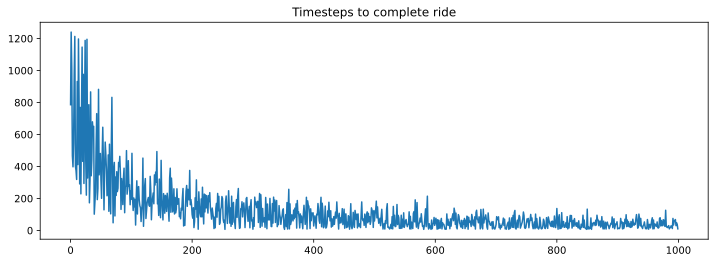

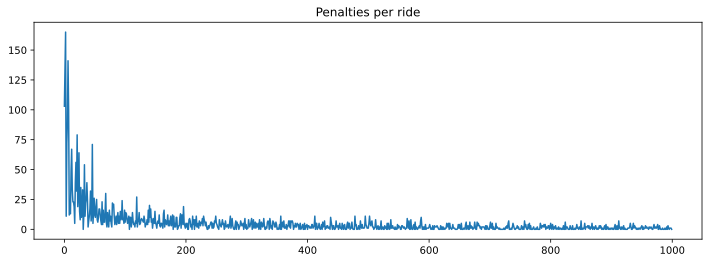

In [18]:
import pandas as pd

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")    
pd.Series(timesteps_per_episode).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")    
pd.Series(penalties_per_episode).plot(kind='line')
plt.show()

## Let's see our q-driver in action!